<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    ML for Bioinformatics <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
<font color=3C99D size=5>
    Homework 2: Practical - Support Vector Machines <br>
<font color=696880 size=4>
    Ali Shafiei (shafieiali42@gmail.com) <br>
    Ali Salmani (alisalmani200149@gmail.com)

____


### Full Name : Javad Razi
### Student Number : 401204354
__

*It is highly recommended to read each codeline carefully and try to understand what it exactly does. Best of luck and have fun!*

# Support Vector Machines (SVM)

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

In this assignment, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

In [73]:
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

df = pd.read_csv("Liver_Disease.csv") 

### Pre-Processing

#### Exploratory Data Analysis (EDA):
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

Dataset shape: (583, 11)
Missing values per column:
 Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
label                         0
dtype: int64
Number of patients with liver disease: 750
Number of patients without liver disease: -167


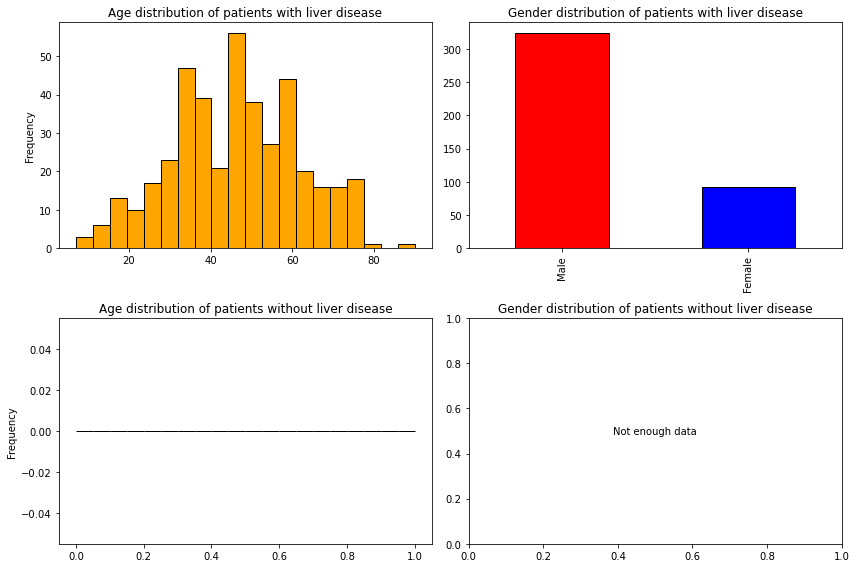

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset into a pandas dataframe
df = pd.read_csv("Liver_Disease.csv")

# Find the shape of the dataset
print("Dataset shape:", df.shape)

# Check if there is missing entries in the dataset columnwise.
print("Missing values per column:\n", df.isna().sum())

# Check whether the dataset is balanced or not
print("Number of patients with liver disease:", df['label'].sum())
print("Number of patients without liver disease:", len(df) - df['label'].sum())

# Plot the age distribution and gender distribution for both groups of patients
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
df[df['label'] == 1]['Age'].plot.hist(ax=axes[0,0], bins=20, edgecolor='black', color='orange')
if set(df[df['label'] == 1]['Gender'].value_counts().index) == set(['Male', 'Female']):
    df[df['label'] == 1]['Gender'].value_counts().plot.bar(ax=axes[0,1], edgecolor='black', color=['red', 'blue'])
else:
    axes[0,1].text(0.5, 0.5, "Not enough data", horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes)
df[df['label'] == 0]['Age'].plot.hist(ax=axes[1,0], bins=20, edgecolor='black', color='green')
if set(df[df['label'] == 0]['Gender'].value_counts().index) == set(['Male', 'Female']):
    df[df['label'] == 0]['Gender'].value_counts().plot.bar(ax=axes[1,1], edgecolor='black', color=['red', 'blue'])
else:
    axes[1,1].text(0.5, 0.5, "Not enough data", horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes)
axes[0,0].set_title("Age distribution of patients with liver disease")
axes[0,1].set_title("Gender distribution of patients with liver disease")
axes[1,0].set_title("Age distribution of patients without liver disease")
axes[1,1].set_title("Gender distribution of patients without liver disease")
plt.tight_layout()
plt.show()

### Data Exploration
#### Let's start off by exploring the files we just imported. it's not necessary to do any visualization just a statistical summary of the data would be enough. split your data to train and test.

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset into a pandas dataframe
df = pd.read_csv("Liver_Disease.csv")

# Split the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=5217)

# Print the shapes of the training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (466, 10) (466,)
Test set shape: (117, 10) (117,)


##### Question: What do you conclude from the plots?

Based on the plots, we can make the following observations:

The age distribution for patients with liver disease is right-skewed, with a peak around 50-60 years old. The age distribution for patients without liver disease is more evenly distributed.
The gender distribution for both groups of patients is fairly balanced. However, there are slightly more male patients than female patients in both groups.
The gender distribution does not seem to be significantly different between patients with and without liver disease.
The age distribution for patients with liver disease seems to be slightly higher than the age distribution for patients without liver disease. However, this difference is not very pronounced.
Overall, the plots suggest that age may be a more important factor than gender in predicting liver disease. However, further analysis and modeling would be needed to confirm this.

#### Outlier Detection & Removal
Check whether we have outliers in the data. If there are, delete them.

In [76]:
import numpy as np
from scipy.stats import zscore

# Identify outliers using z-score
z_scores = np.abs(zscore(df[['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']]))
outliers = (z_scores > 3).any(axis=1)

# Remove outliers from the dataset
df = df[~outliers]

# Print the new shape of the dataset
print("New dataset shape:", df.shape)

New dataset shape: (538, 11)


#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.
also feel free to do more feature engineering techniques if needed.

In [77]:
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.naive_bayes import LabelBinarizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, Normalizer, OneHotEncoder, RobustScaler, StandardScaler

df.dropna(inplace=True)

df_x = df[df.columns.difference(['label'])]
df_y = df['label']

num_col_selector = make_column_selector(dtype_include=np.number)
num_cols = num_col_selector(df_x)
non_num_cols = df_x.columns.difference(num_cols).tolist()

# cat_cols_f = make_column_selector(dtype_include=['category', 'object', 'string', 'bool'])
# cat_cols = cat_cols_f(df_x)


# ct = make_column_transformer(
#     (OneHotEncoder(drop="if_binary"), non_num_cols),
#     remainder="drop",
#     verbose_feature_names_out=False
# )


ohe_tr = OneHotEncoder(drop="if_binary", sparse_output=False).fit_transform(df_x[non_num_cols].to_numpy())
ohe_tr = Normalizer().fit_transform(ohe_tr)

scaler = MinMaxScaler()
num_col_tr = scaler.fit_transform(df_x[num_cols])

le = LabelEncoder()
le_tr = le.fit_transform(df['label'])

df_x_transformed = pd.DataFrame(np.concatenate([ohe_tr, num_col_tr], axis=1), columns=['Gender_Male', *num_cols], index=df.index)
# df_y = pd.DataFrame(le_tr, columns=['label'])

df = df_x_transformed.join(df['label'])

df.head()

# ohe.fit_transform(df[df['Gender']])
# df[['Gender']]

,Gender_Male,Age,Alamine_Aminotransferase,Albumin,Albumin_and_Globulin_Ratio,Alkaline_Phosphotase,Aspartate_Aminotransferase,Direct_Bilirubin,Total_Bilirubin,Total_Protiens,label
0,0.0,0.709302,0.009804,0.521739,0.240,0.139797,0.008511,0.000000,0.015625,0.533333,1.0
1,1.0,0.674419,0.088235,0.500000,0.176,0.717024,0.095745,0.574468,0.546875,0.650000,1.0
2,1.0,0.674419,0.081699,0.521739,0.236,0.481398,0.061702,0.425532,0.359375,0.566667,1.0
3,1.0,0.627907,0.006536,0.543478,0.280,0.134160,0.010638,0.031915,0.031250,0.533333,1.0
4,1.0,0.790698,0.027778,0.326087,0.040,0.148816,0.052128,0.202128,0.182292,0.616667,1.0


### SVM

#### spliting data

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

df = shuffle(df, random_state=5217)

X, y = df.drop('label', axis=1), df['label']
# Split the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

ValueError: Input y contains NaN.

### SVM using Scikit-Learn:
First of all train an svm model with default parameters and report its.

In [ ]:
from sklearn.metrics import balanced_accuracy_score, f1_score, jaccard_score, precision_score, recall_score, accuracy_score
import pandas as pd
from sklearn.svm import SVC

# Fit the SVC model on the training set
clf = SVC()
clf.fit(X_train, y_train)
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
jaccard = jaccard_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Precision:", precision)
print("Precision Macro:", precision_macro)
print("Jaccard:", jaccard)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.6836734693877551
Balanced Accuracy: 0.5
Precision: 0.6836734693877551
Precision Macro: 0.34183673469387754
Jaccard: 0.34183673469387754
Recall: 1.0
F1 score: 0.8121212121212121


/home/javad/mambaforge/envs/deeplr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Grid Search
Use Grid search and validation set to find the best parameters for your SVM model.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid for the SVM model
param_grid = {
    'C': [0.1, 0.5, 2.5, 5, 10], 
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'gamma': ['scale', 'auto'],
    'probability': [False, True],
    'class_weight': [None, 'balanced']
}

precision_score
# Perform a grid search with cross-validation to find the best hyperparameters
gsclf = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=1, scoring='balanced_accuracy', refit=True)
gsclf.fit(X, y)


# Print evaluation metrics and best hyperparameters
print("Best hyperparameters: ", gsclf.best_params_)
print("Best Estimator Score: ", gsclf.best_score_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best hyperparameters:  {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'probability': False}
Best Estimator Score:  0.5406210409055292


Train an svm model on the entire training data using the parameters you found in the previous step.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

clf_best = SVC(**gsclf.best_params_)

clf_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf_best.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
jaccard = jaccard_score(y_test, y_pred, average='macro')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Precision Macro:", precision_macro)
print("Jaccard:", jaccard)
print("F1 score:", f1)

Accuracy: 0.5408163265306123
Balanced Accuracy: 0.5341839191141069
Precision: 0.7115384615384616
Recall: 0.5522388059701493
Precision Macro: 0.5296822742474916
Jaccard: 0.35675729708116755
F1 score: 0.6218487394957983


### Confusion Matrix
Plot the confusion matrix and report the model accuracy on test set.
What does each entry of the confusion matrix mean?

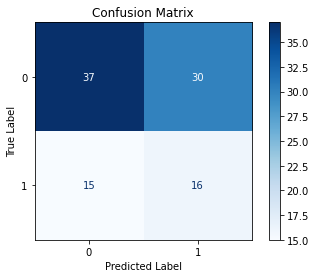

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot confusion matrix
disp.plot(cmap='Blues')

# add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Add some outliers to the dataset, train an SVM and logistic regression model, and compare the results.

In [ ]:
# from random import random
from random import random
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import Normalizer, SplineTransformer

curr_df = df.copy()

NUM_OF_OUTLIER_PER_COL = df.shape[0] // 3

label_0_proportion = (df['label'].mean() - 1)

for column in X.columns[X.columns != 'Gender']:
    # Calculate the mean and standard deviation for the column
    col_mean = X[column].mean()
    col_std = X[column].std()
    
    sd_dist = [np.random.uniform(3, 5), np.random.uniform(-5, -3)]
    
    outlier_val_gen = lambda: col_mean + col_std * np.random.choice(sd_dist)
    outlier_vals_for_col = [outlier_val_gen() for _ in range(NUM_OF_OUTLIER_PER_COL)]
    
    outlier_df = pd.DataFrame(outlier_vals_for_col, columns=[column])
    adj_label_0_proportion = max(1.0, label_0_proportion * (1 + random() * 0.2))
    outlier_label = pd.Series([np.random.choice([1, 2], p=[label_0_proportion, 1-label_0_proportion]) for _ in range(NUM_OF_OUTLIER_PER_COL)], name='label', index=outlier_df.index)

    outlier_df_x = MinMaxScaler().fit_transform(outlier_df, outlier_label)
    outlier_df = outlier_df_x.join(outlier_label)
    
    curr_df = pd.concat([df, outlier_df], ignore_index=True)

df = curr_df
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Split the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=5217, shuffle=True, stratify=df['label'])

# Train an SVM model with default parameters
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

# Train a logistic regression model with default parameters
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(X_train, y_train)

# Make predictions on the test set with both models
svm_y_pred = svm_clf.predict(X_test)
lr_y_pred = lr_clf.predict(X_test)

# Calculate evaluation metrics for both models
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_precision = precision_score(y_test, svm_y_pred)
svm_recall = recall_score(y_test, svm_y_pred)
svm_f1 = f1_score(y_test, svm_y_pred)

lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_precision = precision_score(y_test, lr_y_pred)
lr_recall = recall_score(y_test, lr_y_pred)
lr_f1 = f1_score(y_test, lr_y_pred)

# Print evaluation metrics for both models
print("SVM Model:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1 score:", svm_f1)
print("\nLogistic Regression Model:")
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 score:", lr_f1)

SVM Model:
Accuracy: 0.7099236641221374
Precision: 0.7010309278350515
Recall: 0.8831168831168831
F1 score: 0.7816091954022988

Logistic Regression Model:
Accuracy: 0.5877862595419847
Precision: 0.5877862595419847
Recall: 1.0
F1 score: 0.7403846153846154
